In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In E:\Users\Mani\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In E:\Users\Mani\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In E:\Users\Mani\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In E:\Users\Mani\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In E:\Users\Mani\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
messages = pd.read_csv('Railways dataset - Clean.csv')
messages.head()

,Rating,Review
0,1,Worst and pathetic services that anyone can pr...
1,1,PNR-2537404628\nTrn:12056\nDt:02-03-20\nFrm DD...
2,1,I've always faced this issue whenever I travel...
3,2,IRCTC:- Drama of sleeping by administrator\r\n...
4,1,Wow as you can see that cleanness of the train...


In [5]:
messages["Sentiment"] = messages["Rating"].apply(lambda score: "Positive" if score >3  else "Negative")
messages.head()

,Rating,Review,Sentiment
0,1,Worst and pathetic services that anyone can pr...,Negative
1,1,PNR-2537404628\nTrn:12056\nDt:02-03-20\nFrm DD...,Negative
2,1,I've always faced this issue whenever I travel...,Negative
3,2,IRCTC:- Drama of sleeping by administrator\r\n...,Negative
4,1,Wow as you can see that cleanness of the train...,Negative


In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
import nltk

cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

messages["Summary_Clean"] = messages["Review"].apply(cleanup)

train, test = train_test_split(messages, test_size=0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))



134 items in training data, 34 in test data


In [8]:
from wordcloud import WordCloud, STOPWORDS

# To cleanup stop words, add stop_words = STOPWORDS
# But it seems to function better without it
count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = count_vect.fit_transform(train["Summary_Clean"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = count_vect.transform(test["Summary_Clean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["Review"]
y_test = test["Review"]

prediction = dict()

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, max_df=10, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(messages.Review).toarray()
labels = messages.Review
features.shape

(168, 21671)

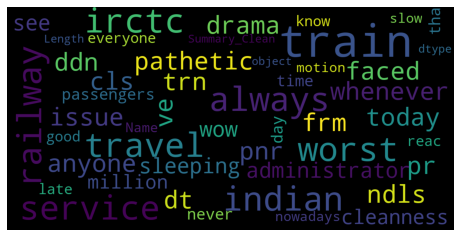

In [10]:
#Let's get fancy with WordClouds!

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
#mpl.rcParams['font.size']=12                #10 
#mpl.rcParams['savefig.dpi']=100             #72 
#mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(messages["Summary_Clean"])


In [11]:
#Applying Multinomial Naïve Bayes learning method¶
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

In [13]:
#Applying Bernoulli Naïve Bayes learning method¶
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

In [14]:
#Applying Logistic regression learning method¶

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

In [20]:
def test_sample(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), prob[0], prob[1]))

test_sample(logreg, "WORST EXPERIENCE")

Sample estimated as VERY WORST EXPERIENCE TO TRAVEL IN THIS TRAIN STARTED ON JAN-01-2020. THIS TRAIN IS 10HR LATE TILL THE DESTINATION.THERE IS PANTRY, NO GOOD TOILETS, 3AC COACHES ALSO NOT CLEAN.
: negative prob 0.009392, positive prob 0.005785
